## Problem formulation

Grain-based microstructures occur in nature but also develop during industrial processes. We are interested in how the size and the distribution of grains, and the material they are made up of influence the resistance of train wheels and axles to fatigue loading. The problem requires that

- the individual grains can be distinguished on a microscopic image
- a good quality mesh is generated on the microstructure
- the numerical solution obtained on this mesh can be compared to full-field measurements

The first two steps are discussed here.

## Initial setup

First, we switch to the root directory of the project so that the package imports are consistent. Note that the relative path always works because the current directory in case of a Jupyter notebook is always the directory in which the notebook is.

In [1]:
import os
os.chdir('../')
main_dir = os.path.abspath(os.curdir)

Let us set the directory that will hold our data.

In [2]:
data_dir = os.path.abspath('data')
try:
    os.mkdir(data_dir)
except FileExistsError:
    pass

We now copy the necessary data files that come with *CristalX* into this freshly created directory.

In [3]:
from os.path import join
from shutil import copy
selected_files = ['1.png', '1_cropped.png', 'splinegons.png', '1_mesh_extended.npz']
for file in selected_files:
    copy(join('scripts/data', file), data_dir)

In interactive mode, debug information are displayed. They are not useful for presentation purposes as they pollute the rendered output. Similarly for runtime warnings.

In [4]:
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.simplefilter('ignore')

For the figures to be visible in this notebook, we define a utility function to scale them.

In [5]:
import matplotlib.pyplot as plt
def scale_figure(dpi):
    plt.gcf().set_dpi(dpi)

## Identify grains in a microstructure

The picture below was taken with a digital camera and shows the central part of a tensile specimen. In this section, we will identify the individual grains in the image.

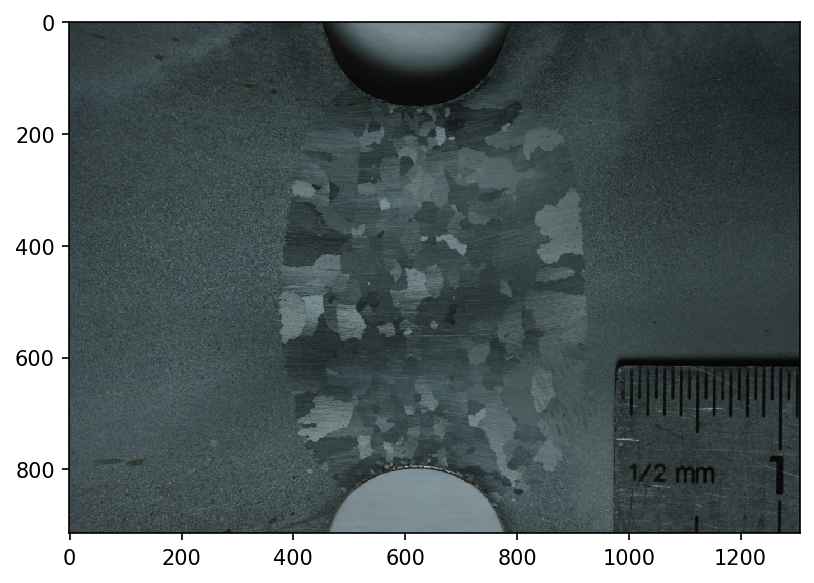

In [6]:
from skimage.io import imshow
imshow(join(data_dir, '1.png'))
scale_figure(150)

So that the surrounding region does not interfere with the segmentation, we will work on a cropped region.

In [7]:
from skimage.io import imread
import numpy as np
image = join(data_dir, '1_cropped.png')

As you can see, the RGB image is represented as a 3D numpy array.

In [8]:
image_as_matrix = imread(image)
type(image_as_matrix), image_as_matrix.shape

(numpy.ndarray, (638, 589, 3))

However, you do not explicitly have to deal with this matrix as the `Segmentation` class will handle it.

The `Segmentation` class offers a set of methods to perform the consecutive steps of the segmentation workflow. We pass to the constructor the path to the image to be segmented. By default, the resulting images are shown at the end of each step. In batch mode, you probably want to set the `interactive_mode` optional parameter to `False`. But in this interactive document, we want to see the outputs.

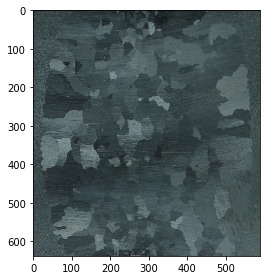

Image successfully loaded.


In [9]:
from grains.segmentation import Segmentation
GS = Segmentation(image)

After the image has been loaded and stored in the `GS` object, we want to remove the noise. Since the interfaces among the grains are important for us, we use median filtering for smoothing as it preserves the contours. The smoothing is governed by the *window size*. The larger this number, the smoother the processed image is, and the higher the computational cost becomes.

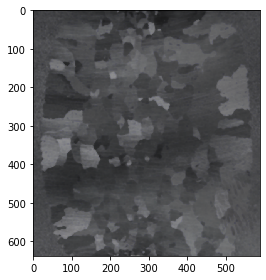

Median filtering finished.


In [10]:
filter_window_size = 5
filtered = GS.filter_image(filter_window_size)

To improve the segmentation result later, we perform *superpixel segmentation* as an initial step. During this process, the image is subdivided into superpixels, groups of pixels that belong together based on colour, spatial
distance or other properties. On this image, a superpixel algorithm called *Quick Shift* proved to be the best among the algorithms available in *scikit-image*.

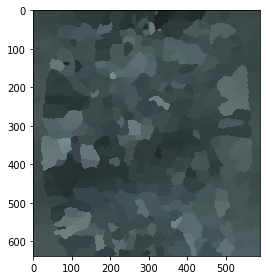

Quick shift segmentation finished. Number of segments: 421


In [11]:
segmented = GS.initial_segmentation(filtered)

The result is indeed a segmented (also called labelled) image. Distinct positive integers, called labels, are associated to groups of pixels in the labelled image and each pixel belongs to one and only one such group.

In [12]:
segmented

array([[  8,   8,   8, ...,   2,   2,   2],
       [  8,   8,   8, ...,   2,   2,   2],
       [  8,   8,   8, ...,   2,   2,   2],
       ...,
       [400, 400, 400, ..., 414, 414, 414],
       [400, 400, 400, ..., 414, 414, 414],
       [400, 400, 400, ..., 414, 414, 414]])

The segmented image has the same size as the original image, but it is not an RGB image any more.

In [13]:
segmented.shape, image_as_matrix.shape

((638, 589), (638, 589, 3))

We can visualize a labelled image by associating different colours to the different labels.

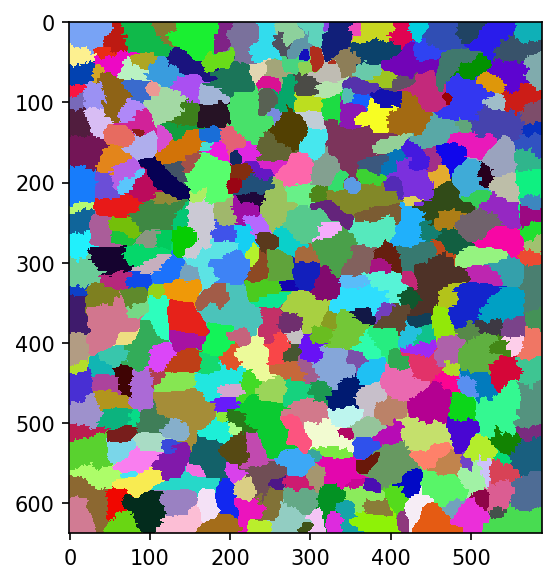

In [14]:
from skimage.color import label2rgb
from numpy.random import random
nlabel = len(np.unique(segmented))
imshow(label2rgb(segmented, colors=random((nlabel, 3))))
scale_figure(150)

As the superpixel segmentation in the previous step resulted in an oversegmented image, the region adjacency graph is constructed and used to merge some of the neighbouring superpixels based on their similarity with respect to mean colour. Regions connected by edges with smaller weights than a prescribed threshold are combined. As you can see, the number of supersegments decreases.

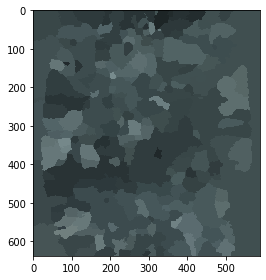

Tiny clusters merged. Number of segments: 177


In [15]:
cluster_merging_threshold = 7
reduced = GS.merge_clusters(segmented, threshold=cluster_merging_threshold)

We need a few more steps before succesfully applying another segmentation technique to obtain the final segmented image. First, we detect the grain boundaries. They are shown superposed on the original image.

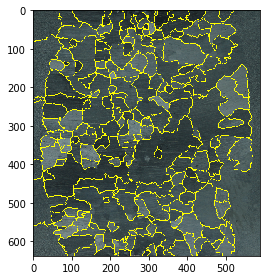

Grain boundaries found.


In [16]:
boundary = GS.find_grain_boundaries(reduced)

The boundary image is a binary image in which the `True` values indicate the boundaries among the labelled regions.

In [17]:
boundary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

The we use thinning on the grain boundary to obtain a single-pixel wide skeleton. 

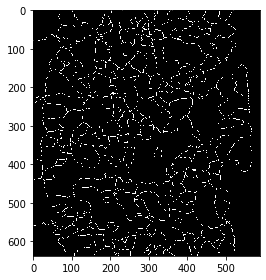

Skeleton constructed.


In [18]:
skeleton = GS.create_skeleton(boundary)

If the automatic segmentation carried out so far is not good enough, the user can manually edit the skeleton as a graph in [ImagePy](https://github.com/Image-Py/imagepy). The combination of the automatic segmentation with human supervision is a powerful way to achieve good results in a relatively short amount of time. Here, we stay with the automatic method.

To recover the segments again, we use *watershed segmentation* on the skeleton. Had it been directly applied on the original image, the result of the watershed segmentation would have been an oversegmented image due to the noises that act as local minima. The success of the watershed segmentation depends on how well the catchment basins are identified, which are the locations where the flooding starts. The so-called marker-based watershed segmentation methods rely on markers (computed automatically or given by the user), i.e. the location of the catchment basins, as inputs. In the `watershed_segmentation` method of the `Segmentation` class, various transformations are used to obtain a desirable outcome.

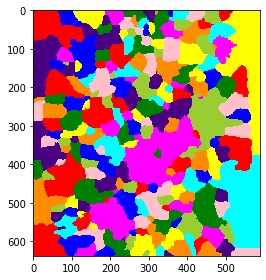

Watershed segmentation finished. Number of segments: 247


In [19]:
watershed = GS.watershed_segmentation(skeleton)

To the left and to the right of the central zone, artificial "grains" appear. This is not a problem, they can either be merged, or left as it is and associate the same material to them.

## Extending the image domain

The segmented image corresponds to the recrystallized part of the specimen. When we perform the traction test numerically we need a larger domain, the boundary on which the boundary conditions are applied. The size of this extended domain does not have to match with the physical size of the tensile specimen, but it has to be sufficiently large so that the far-field boundary conditions do no not influence the deformation state in the central region.

As a first step, we extend the domain by padding the corresponding numpy array. Since we want to handle the added domains (grains) on the left and on the right as separate grains, we associate different labels to them. There are about 250 grains in the central region, so choosing labels 500 and 501 ensures that these regions have unique labels.

The extended domain is constructed in such a way that it matches the region of the DIC measurements. This will be useful when comparing the results of the simulation with the experimental data.

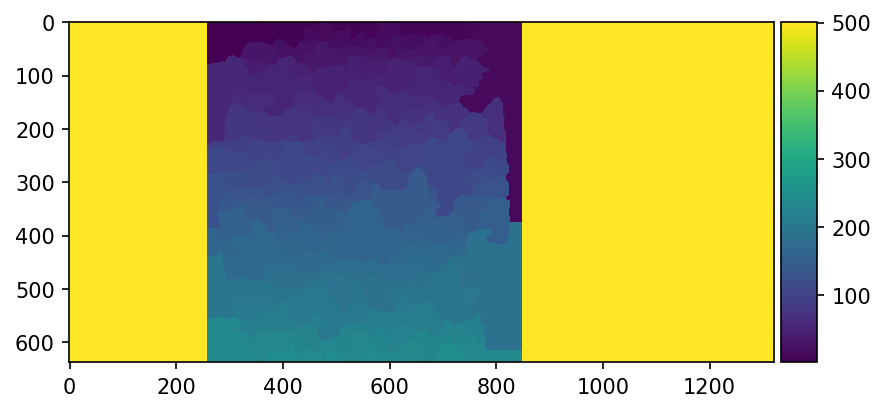

In [20]:
from grains.simulation import change_domain
extended_image = change_domain(watershed, 0.4395, 0, 0, 0, 500)
extended_image = change_domain(extended_image, 0, 0.5568, 0, 0, 501)
imshow(extended_image)
scale_figure(150)

## From image to geometry

In this section, we show how to represent the grains as an explicit geometry. See our paper for the motivation.

For grain representation, we can choose between polygon and splinegon approximations. We will base the meshing on the splinegon representation, but the polygons are also shown. The high-level functions `polygonize` and `splinegonize` wrap all the important algorithms. You can see from the code below that they share similar function signature. The only difference is that the spline parameters can be provided to the `splinegonize` function.

In [21]:
from grains.cad import polygonize, search_neighbor, splinegonize
polygons = polygonize(extended_image, search_neighbor(2, np.inf), connectivity=1)
splinegons, _ = splinegonize(extended_image, search_neighbor(2, np.inf), connectivity=1, degree_min=3, degree_max=3, continuity='C0', tol=1)

Let us plot the grains. For polygons:

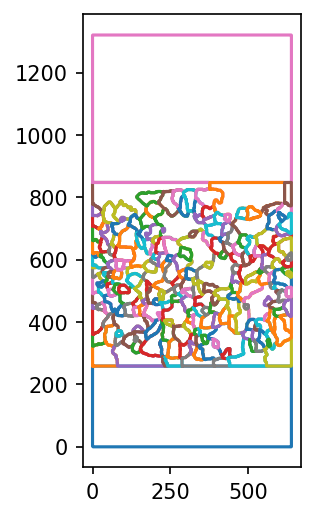

In [22]:
from grains.cad import plot_polygons
plot_polygons(list(polygons.values()));
scale_figure(150)

Plotting the spline surfaces will bring up a window.

In [23]:
from grains.cad import plot_splinegons
from OCC.Display.SimpleGui import init_display
plot_splinegons(list(splinegons.values()), color=(0, 0, 1))

Layer manager created
Layer dimensions: 1024, 768


To allow reading this document statically, here is a screenshot of the window that popped up.

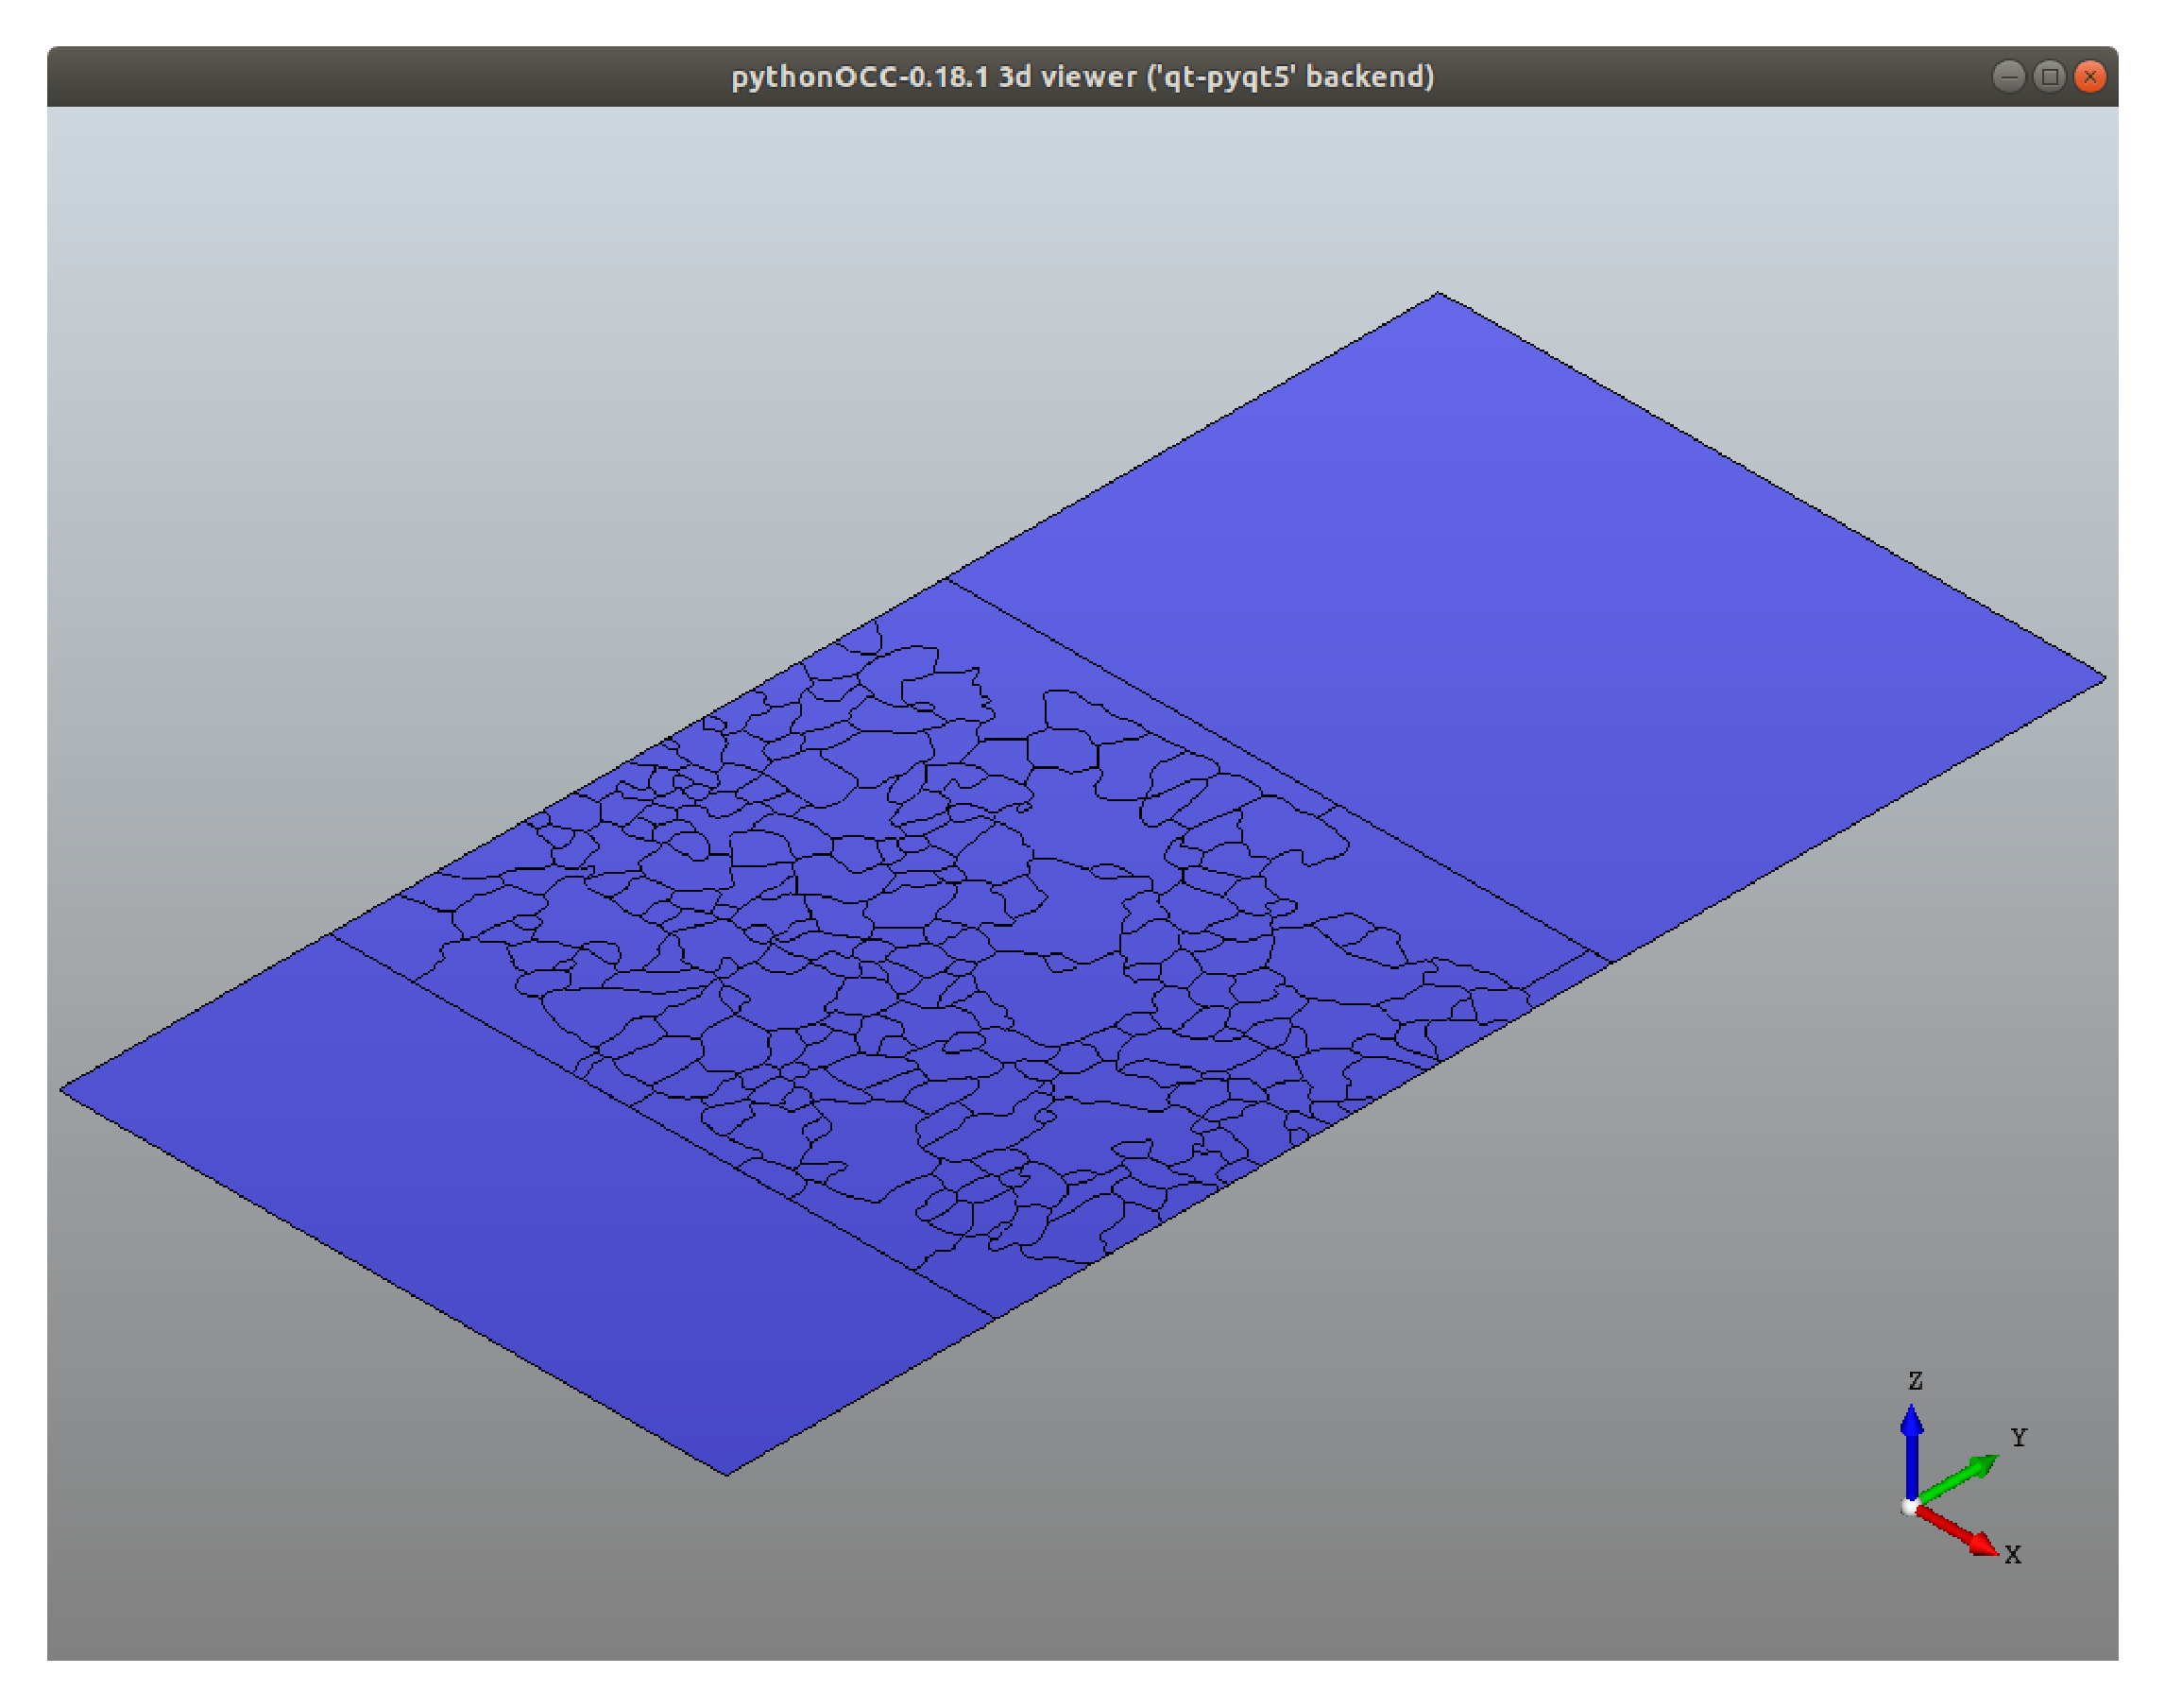

In [24]:
fig, ax = plt.subplots(dpi=500)
imshow(join(data_dir, 'splinegons.png'), ax=ax)
ax.set_axis_off()

Once we have the spline surfaces, we write them to a STEP file. This allows us to edit the geometry in a CAD program and to generate a mesh for the grains.

In [25]:
from grains.cad import regions2step
regions2step(list(splinegons.values()), join(data_dir, 'microstructure.stp'))

## Repairing the geometry

For the sample microstructure, one grain was not identified, i.e. it contains a hole. The hole can be filled in by creating a new grain. We have a [detailed guide](https://cristalx.readthedocs.io/en/latest/salome.html) on how to do this.

## Mesh generation

The same guide linked in the previous section continues with the mesh generation. It happens that we constructed the conforming mesh in Salome, and then exported it to a .med file. Using the [*med* module](https://cristalx.readthedocs.io/en/latest/api.html#module-grains.med) of *CristalX*, the triangular mesh cells for each grain and the boundary nodes have been extracted. We also have a [tutorial on how to process a .med file](https://cristalx.readthedocs.io/en/latest/med.html).

## Modifying the mesh

First, we obtain the mesh data that was saved using the `med` module.

In [26]:
mesh_file = join(data_dir, '1_mesh_extended.npz')
with np.load(mesh_file, allow_pickle=True) as mesh:
    nodes = mesh['nodes']
    elements = mesh['elements']
    element_groups = mesh['element_groups']
    node_groups = mesh['node_groups']
# Retrieve groups, which were stored in dictionaries (https://stackoverflow.com/a/40220343/4892892)
element_groups = element_groups.item()
node_groups = node_groups.item()

The array `elements` contains the label of the nodes in the mesh.

In [27]:
elements

array([[  603,   604,  4311],
       [  604,    19,   605],
       [  606,    18,  4312],
       ...,
       [13377, 13369, 13374],
       [13372, 13377, 13373],
       [13373, 13370, 13372]])

The array `nodes` holds the coordinates of each node of the mesh.

In [28]:
nodes

array([[2.50000000e-01, 2.59000000e+02],
       [8.00000000e+01, 2.59250000e+02],
       [2.31000000e+02, 2.59250000e+02],
       ...,
       [6.28062814e+02, 8.02235833e+02],
       [6.22855688e+02, 7.95968504e+02],
       [6.23756131e+02, 7.89612749e+02]])

The elements are available for each grain. For instance, grain 87 is labelled as *Face_87* and it contains the following elements.

In [29]:
element_groups['Face_87']

array([23231, 23232, 23233, 23234, 23235, 23236, 23237, 23238, 23239,
       23240, 23241, 23242, 23243, 23244, 23245])

We mentioned earlier that some grains are artefacts of the watershed segmentation. In other words, they are outside the recrystallized central region. Therefore, those grains along with the two extensions (that were given the labels 500 and 501) were merged in Salome and a single mesh was constructed on the merged region. That region contains the most elements.

In [30]:
len(element_groups['homogeneous'])

3718

To be able to prescribe boundary conditions later, the boundary nodes were also exported from Salome.

In [31]:
node_groups

{'bottom': array([   8,   14,  448,  452,  467,  468,  470,  471,  472,  474,  475,
         477,  478,  479,  480,  481,  482,  495,  496,  497,  498,  499,
         557,  558,  559,  560,  561,  562,  563,  564,  565, 3673, 3674,
        3675, 3676, 3706, 3707, 3708, 3839, 3840, 3841, 3842, 3851, 3852,
        3861, 3862, 3863, 3864, 3865, 3866, 3867, 3874, 3880, 3881, 3882,
        3883, 3884, 3885, 3886, 3887, 3888, 3895, 3896, 3897, 3914, 3915,
        3922, 3923, 3924, 3925, 3926, 3930, 3931, 3932, 3933, 3943, 3944,
        3945, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960,
        3961, 3962, 3963, 3964], dtype=int32),
 'left': array([  9,  10, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493,
        494], dtype=int32),
 'right': array([ 15,  16, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555,
        556], dtype=int32),
 'top': array([   0,   11,   17,   20,   21,   25,   28,   33,   34,   36,   44,
          45,   46,   52,   61,   63,  541,  542,  

Handling all these data individually is tedious. Hence, we created a mesh class that bundles them and defines operations on them. The `TriMesh` class is an abstraction for a triangular mesh. First, we initialize it with the elements and the nodes that were loaded from the *1_mesh_extended.npz* file.

In [32]:
from grains.geometry import TriMesh
mesh = TriMesh(nodes, elements)

The `TriMesh` class has several options to plot the mesh, for now we consider the default plotting.

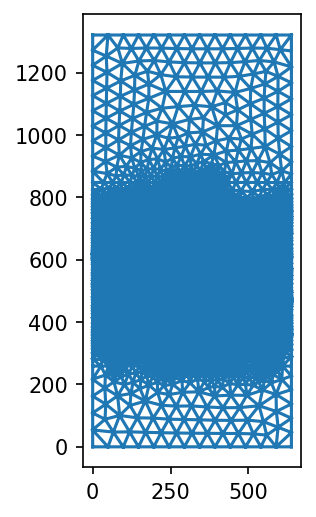

In [33]:
mesh.plot()
scale_figure(150)

Then the element and node sets are associated to the mesh object.

In [34]:
# Associate the element and node groups to it
for group_name, elements in element_groups.items():
    mesh.create_cell_set(group_name, elements)
for group_name, nodes in node_groups.items():
    mesh.create_vertex_set(group_name, nodes)

Mesh-based discretization methods often presume that the node ordering within an element is counter-clockwise. To make sure this is the case, we explicitly enforce it.

In [35]:
mesh.change_vertex_numbering('ccw', inplace=True);

The mesh was created on the geometry, which was constructed based on the image, i.e. in pixel units. For the simulation to be comparable with the experimental data (full-field measurement), the real size of the tensile speciment must be given. In the first image of this notebook, you can observe a ruler. With the help of it, we set the correspondance between the physical unit and the pixel unit: there are 29.55 pixels in 1 mm.

In [36]:
mesh.scale(1/29.55, inplace=True);

For convenience, we rotate the specimen so that its axis is parallel to the horizontal tensile loading.

In [37]:
from math import pi
mesh.rotate(-pi/2, inplace=True);

Let us check if this is what we wanted.

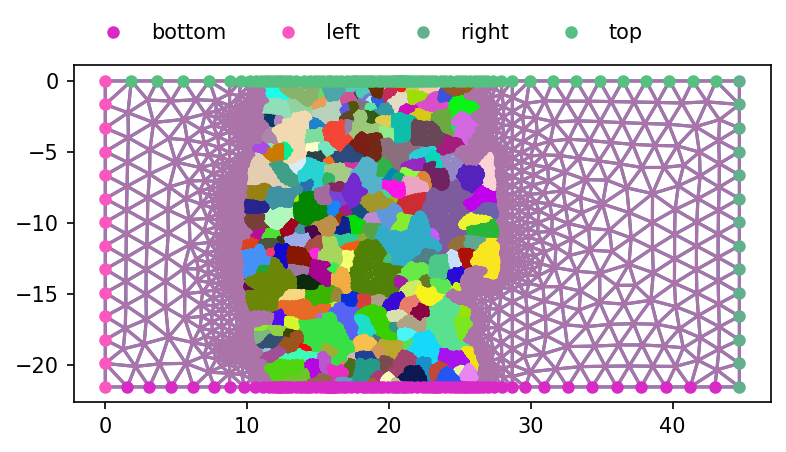

In [38]:
mesh.plot(vertex_legends=True)
scale_figure(150)

We are satisfied with the resulting transformations, so let us save them.

In [39]:
np.savez_compressed(join(data_dir, '1_mesh_extended_scaled.npz'),
                    nodes=mesh.vertices, elements=mesh.cells,
                    element_groups=mesh.cell_sets, node_groups=mesh.vertex_sets)

## Conclusions

We successfully obtained a good quality mesh starting from an image.

In the near future, we will solve an inverse problem to identify characteristic parameters in the constitutive model. This optimization task requires the comparison of the numerical solution obtained on the mesh with the measured field values acquired through digital image correlation (DIC). Some of this work is already available in the `dic` and `simulation` modules.

This document is meant to serve as a global overview of what *CristalX* can be used for. Feel free to play with the parameters to investigate their effects. The functions and classes of *CristalX* provide many more functionalities. Browse the [documentation](https://cristalx.readthedocs.io/en/latest/) to familiarize yourself with the details.

---

The initially created directory (`data/`) is now deleted.

In [40]:
from shutil import rmtree
try:
    rmtree(data_dir)
except FileNotFoundError:
    pass